# Assignment-16-Neural Networks-Gas Turbines

### Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.

The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine.\
The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.\

**Attribute Information:**

The explanations of sensor measurements and their brief statistics are given below.

Variable (Abbr.) Unit Min Max Mean \
Ambient temperature (AT) C â€“6.23 37.10 17.71\
Ambient pressure (AP) mbar 985.85 1036.56 1013.07\
Ambient humidity (AH) (%) 24.08 100.20 77.87\
Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93\
Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56\
Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43\
Turbine after temperature (TAT) C 511.04 550.61 546.16\
Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06\
Turbine energy yield (TEY) MWH 100.02 179.50 133.51\
Carbon monoxide (CO) mg/m3 0.00 44.10 2.37\
Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

In [1]:
# import librabries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
#!pip install keras tensorflow
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error,explained_variance_score
from keras import callbacks

In [2]:
# import dataset
df = pd.read_csv('dataset/gas_turbines.csv')
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [3]:
#shift column 'TEY' to first position
first_column = df.pop('TEY')
df.insert(0, 'TEY', first_column)
df.head()

,TEY,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,114.70,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,10.605,3.1547,82.722
1,114.72,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,10.598,3.2363,82.776
2,114.71,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,10.601,3.2012,82.468
3,114.72,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,10.606,3.1923,82.670
4,114.72,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,10.612,3.2484,82.311


In [4]:
columns=df.columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEY     15039 non-null  float64
 1   AT      15039 non-null  float64
 2   AP      15039 non-null  float64
 3   AH      15039 non-null  float64
 4   AFDP    15039 non-null  float64
 5   GTEP    15039 non-null  float64
 6   TIT     15039 non-null  float64
 7   TAT     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


<AxesSubplot:>

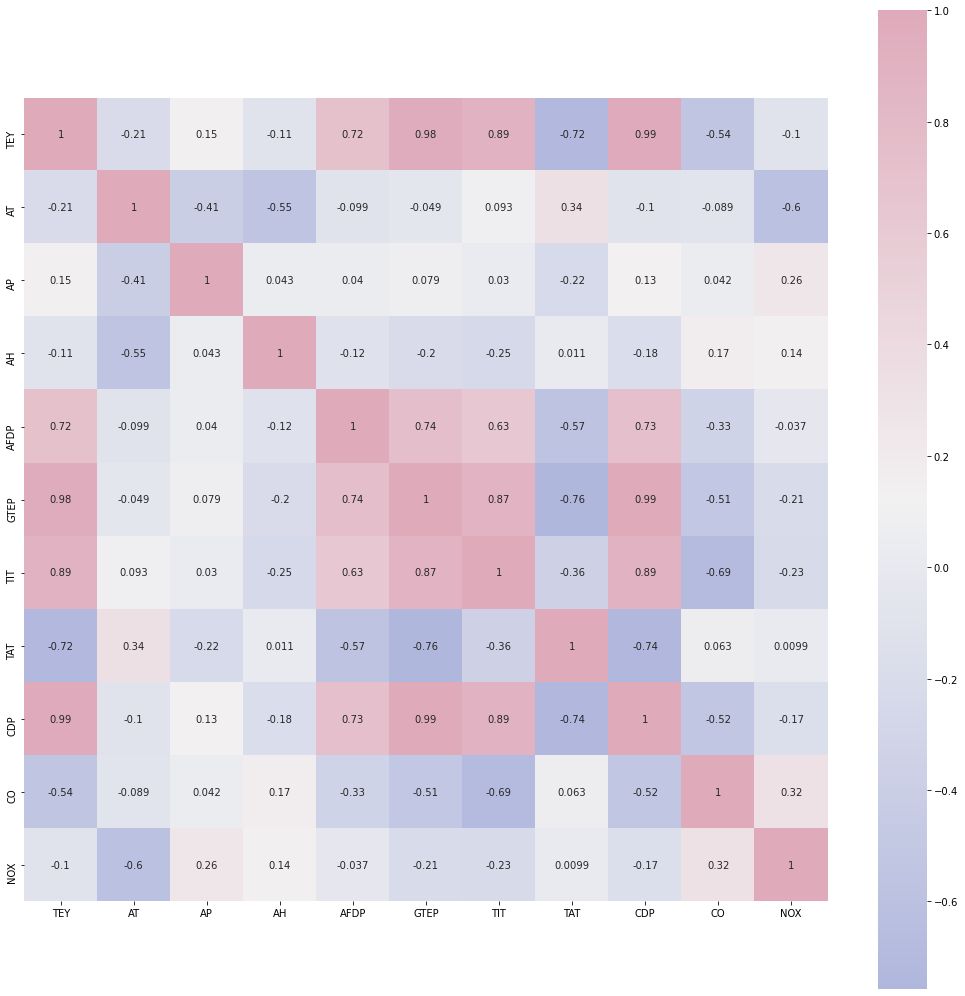

In [6]:
# Correlation amongst numeric attributes
corrmat = df.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [7]:
target_corr = df.corr()['TEY'].sort_values(ascending=False)
print(target_corr)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64


In [8]:
s_scaler = StandardScaler()
df = s_scaler.fit_transform(df)
df = pd.DataFrame(df,columns=columns)

In [9]:
#split features and target
features = df.iloc[:,1:]
target = df.iloc[:,0]

In [10]:
# Feature Scaling to optimize 
col_names = list(features.columns)
features = pd.DataFrame(features, columns=col_names)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,-1.169680e-15,1.000033,-2.276462,-0.839229,0.055666,0.805131,2.266234
AP,15039.0,-1.925280e-14,1.000033,-4.266288,-0.670651,-0.062279,0.577292,3.275970
AH,15039.0,2.007245e-16,1.000033,-3.536594,-0.679634,0.227784,0.791658,1.528011
AFDP,15039.0,3.810001e-16,1.000033,-2.779497,-0.626693,-0.018541,0.461220,4.486233
GTEP,15039.0,1.111478e-16,1.000033,-1.806771,-0.509146,-0.080757,0.422864,2.871006
TIT,15039.0,-2.324212e-15,1.000033,-5.021933,-0.254051,0.296554,0.738249,1.028678
TAT,15039.0,1.744899e-15,1.000033,-4.188141,-0.410115,0.571257,0.592868,0.662784
CDP,15039.0,2.542166e-16,1.000033,-1.992416,-0.435434,-0.070119,0.431168,2.700105
CO,15039.0,1.959261e-17,1.000033,-0.887486,-0.501520,-0.262045,0.084559,18.959494
NOX,15039.0,-3.646853e-17,1.000033,-3.861033,-0.657811,-0.151853,0.548657,4.937717


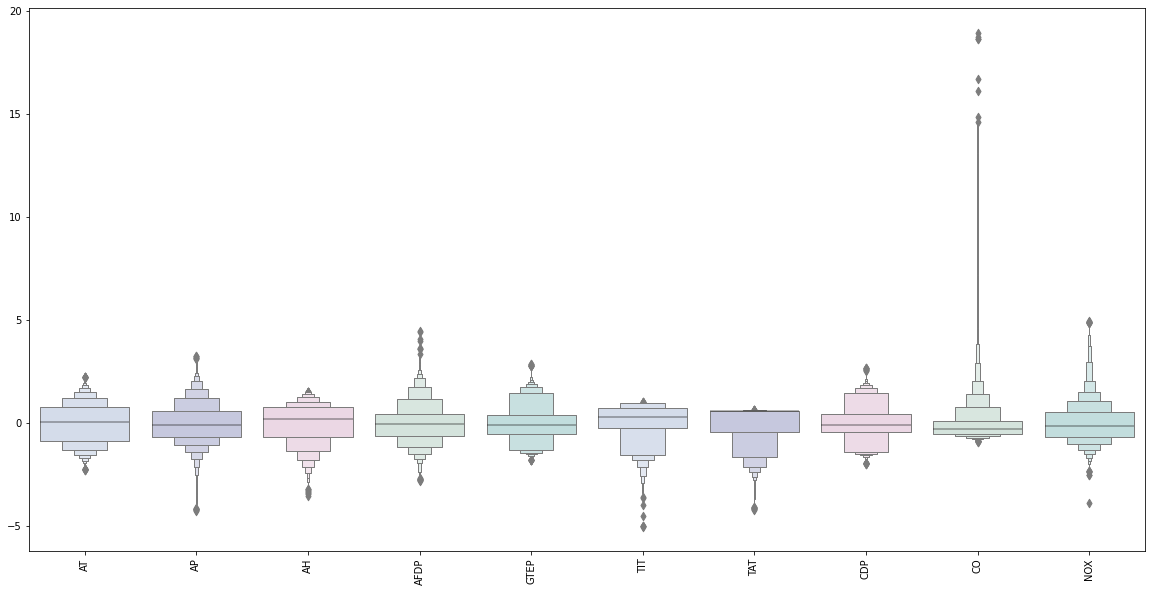

In [11]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [12]:
# # handling outliers using z score
# from scipy import stats
# import numpy as np
# z = np.abs(stats.zscore(features))
# threshold = 3
# features_o = features[(z < 3).all(axis=1)]
# print(features.shape, features_o.shape)
#looking at the scaled features without outliers
# plt.figure(figsize=(20,10))
# sns.boxenplot(data = features_o,palette = colours)
# plt.xticks(rotation=90)
# plt.show()

In [13]:
#Dropping with outlier manually
# features = features[(features["AT"]<2.3)&(features["AT"]>-2.3)]
# features = features[(features["AP"]<2.8)&(features["AP"]>-2.8)]
# features = features[(features["AH"]>-2.8)]
# features = features[(features["AFDP"]<2.5)&(features["AFDP"]>-2.5)]
# features = features[(features["GTEP"]<2.3)&(features["GTEP"]>-1.8)]
# features = features[(features["TIT"]< 1.3)&(features["TIT"]>-2.8)]
# features = features[(features["TAT"]< 0.6)&(features["TAT"]>-2.8)]
# features = features[(features["CDP"]<2.3)&(features["CDP"]>-1.8)]
# features = features[(features["CO"]<2.5)&(features["CO"]>-2)]
# features = features[(features["NOX"]<2.7)&(features["NOX"]>-2.3)]

# features.shape

AT      1.644360
AP      1.247943
AH      1.471292
AFDP    1.087913
GTEP    0.932010
TIT     0.992300
TAT     1.002982
CDP     0.866602
CO      0.586079
NOX     1.206467
dtype: float64
(11405, 11) (15039, 11)


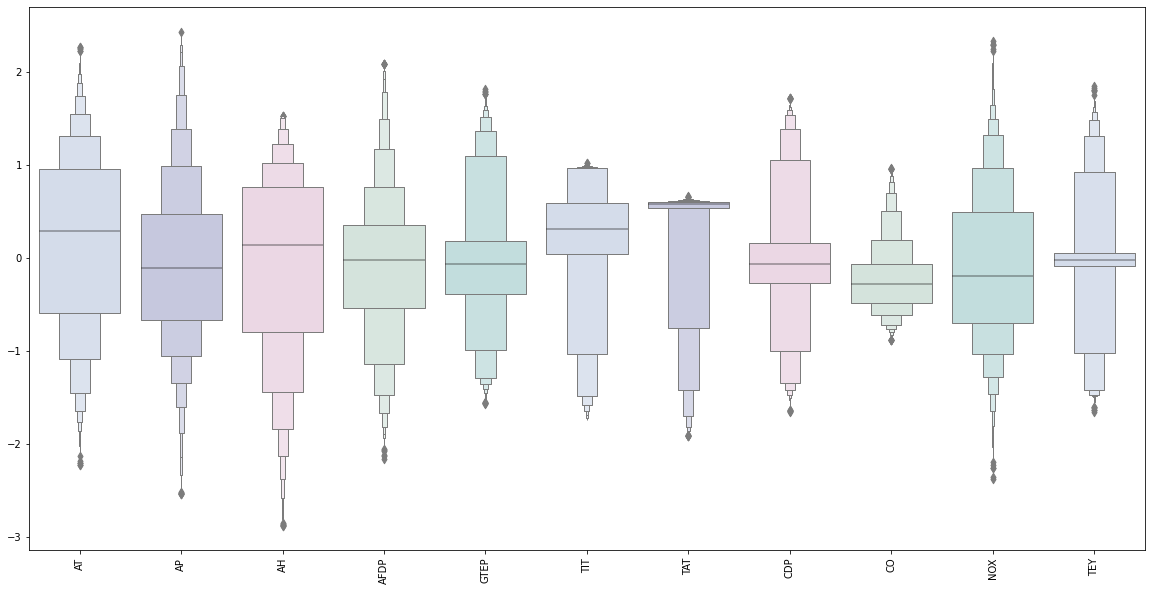

In [14]:
#handling outliers using IQR
Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3-Q1
print(IQR)
features['TEY'] = target
features_iqr = features[~((features < (Q1 -1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)]
print(features_iqr.shape, features.shape)

#looking at the scaled features without outliers
plt.figure(figsize=(20,10))
sns.boxenplot(data = features_iqr,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [15]:
X = features_iqr
y = features_iqr['TEY']
# Splitting test and training sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7983, 11), (7983,), (3422, 11), (3422,))

In [17]:
# Function to generate Deep ANN model
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
def build_regressor(optimizer):
    model = Sequential()
    model.add(Dense(units = 32, kernel_initializer = 'normal', activation = 'relu', input_dim = x_train.shape[1]))
    model.add(Dense(units = 32, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(units = 16, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units = 8, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, kernel_initializer = 'normal'))
    # Compiling the ANN
    model.compile(loss='mean_absolute_percentage_error', optimizer=optimizer)
    return model

# Listing all the parameters to try
param_grid = {
    'batch_size':[10,20,30],
    'epochs':[10,50,100],
    'optimizer':['adam', 'rmsprop']
    }

# Creating the regression ANN model
regressor =KerasRegressor(build_regressor, verbose=0)


# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)

custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)

#########################################
# Creating the Grid search space
grid_search=GridSearchCV(estimator=regressor, 
                         param_grid=param_grid, 
                         scoring=custom_Scoring, 
                         cv=5,
                         verbose=3,
                         n_jobs=-1)

#########################################
# Measuring how much time it took to find the best params
import time
StartTime=time.time()

# Running Grid Search for different paramenters
grid_result = grid_search.fit(x_train, y_train, callbacks=[early_stopping], validation_split=0.3)

EndTime=time.time()
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 21.0min finished


########## Total Time Taken:  21 Minutes


In [18]:
print('### Printing Best parameters ###')
grid_result.best_params_

### Printing Best parameters ###


{'batch_size': 30, 'epochs': 50, 'optimizer': 'adam'}

In [19]:
print('### Printing Best accuracy ###')
grid_result.best_score_

### Printing Best accuracy ###


112.94548384143688

In [20]:
# build neural network with best parameters
model = Sequential()
#Add input layer and first hidden layer
model.add(Dense(units = 32, kernel_initializer = 'normal', activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dense(units = 32, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'normal', activation = 'relu'))
#Add dropout layer
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'normal', activation = 'relu'))
#Add dropout layer
model.add(Dropout(0.5))
# Adding the output layer
model.add(Dense(units = 1, kernel_initializer = 'normal'))

In [21]:
# Compiling the ANN
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

In [22]:
# Fitting the data
regressor = model.fit(x_train, y_train, callbacks=[early_stopping], validation_split=0.3, batch_size = 30, epochs = 50)

Epoch 1/50
187/187 [==============================] - 1s 3ms/step - loss: 103.3648 - val_loss: 100.3345
Epoch 2/50
187/187 [==============================] - 0s 2ms/step - loss: 106.0327 - val_loss: 103.4292
Epoch 3/50
187/187 [==============================] - 0s 2ms/step - loss: 101.7282 - val_loss: 89.3811
Epoch 4/50
187/187 [==============================] - 0s 2ms/step - loss: 95.7048 - val_loss: 88.0232
Epoch 5/50
187/187 [==============================] - 0s 2ms/step - loss: 87.5094 - val_loss: 70.1375
Epoch 6/50
187/187 [==============================] - 0s 2ms/step - loss: 90.1794 - val_loss: 72.9888
Epoch 7/50
187/187 [==============================] - 0s 2ms/step - loss: 89.7899 - val_loss: 82.9475
Epoch 8/50
187/187 [==============================] - 0s 2ms/step - loss: 81.2632 - val_loss: 74.1007
Epoch 9/50
187/187 [==============================] - 0s 2ms/step - loss: 82.4475 - val_loss: 73.5019
Epoch 10/50
187/187 [==============================] - 0s 2ms/step - loss: 78

In [23]:
# saving|loading model
#save trained model in h5 format
model.save('gas_turbines_model.h5')
#load trained model
#regressor = load_model('gas_turbines_model.h5')

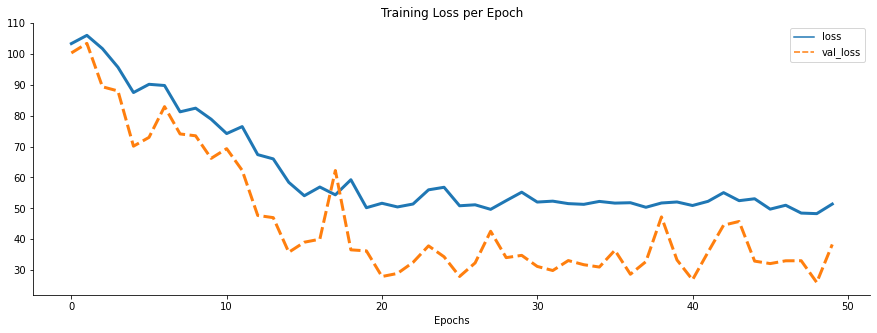

In [24]:
losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()

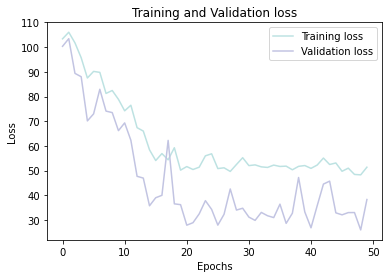

In [25]:
regressor_df = pd.DataFrame(regressor.history)
plt.plot(regressor_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(regressor_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [26]:
# make predictions
y_pred = model.predict(x_test)

In [27]:
print('MAE: ',mean_absolute_error(y_test,y_pred))
print('MSE: ',mean_squared_error(y_test,y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Variance Regression Score: ',explained_variance_score(y_test,y_pred))

MAE:  0.16295990278049335
MSE:  0.06876959407677018
RMSE:  0.26223957381899893
Variance Regression Score:  0.8668183028245676


/home/starlord/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Test True Y'),
 Text(0, 0.5, 'Model Predictions'),
 Text(0.5, 1.0, 'Model Predictions vs Perfect Fit')]

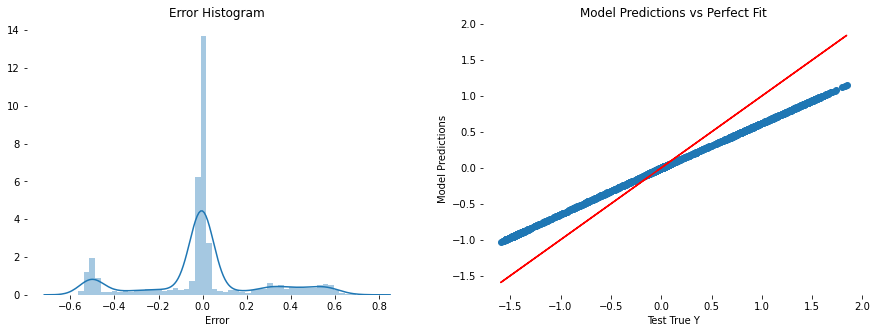

In [28]:
f, axes = plt.subplots(1, 2,figsize=(15,5))

# Our model predictions
plt.scatter(y_test,y_pred)

# Perfect predictions
plt.plot(y_test,y_test,'r')

errors = y_test.values.reshape(y_test.shape[0], 1) - y_pred
sns.distplot(errors, ax=axes[0])

sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Error', ylabel='', title='Error Histogram')
axes[1].set(xlabel='Test True Y', ylabel='Model Predictions', title='Model Predictions vs Perfect Fit')